# Generalized Additive Models
> Using pyGAM

In [33]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

from pygam import LinearGAM, s, f, l, te
from pygam.datasets import wage

In [97]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
#     ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

In [31]:
data = pd.read_csv("Fish.csv")
data

,Species,Length1,Length2,Length3,Height,Width,Weight
0,Bream,23.2,25.4,30.0,11.5200,4.0200,242.0
1,Bream,24.0,26.3,31.2,12.4800,4.3056,290.0
2,Bream,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Bream,26.3,29.0,33.5,12.7300,4.4555,363.0
4,Bream,26.5,29.0,34.0,12.4440,5.1340,430.0
...,...,...,...,...,...,...,...
154,Smelt,11.5,12.2,13.4,2.0904,1.3936,12.2
155,Smelt,11.7,12.4,13.5,2.4300,1.2690,13.4
156,Smelt,12.1,13.0,13.8,2.2770,1.2558,12.2
157,Smelt,13.2,14.3,15.2,2.8728,2.0672,19.7


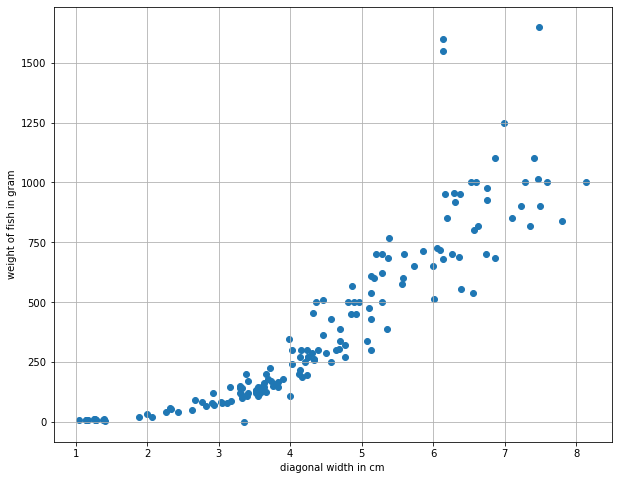

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
y = data.Weight
x = data.Width

plt.scatter(x,y)
plt.ylabel("weight of fish in gram")
plt.xlabel("diagonal width in cm")
plt.grid()

# Polynomial 

In [209]:
result_poly = smf.ols('Weight ~ Width +' + 'I(Width**2)', data=data).fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     374.2
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.96e-60
Time:                        23:28:18   Log-Likelihood:                -1020.4
No. Observations:                 159   AIC:                             2047.
Df Residuals:                     156   BIC:                             2056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -74.5818     67.333     -1.108

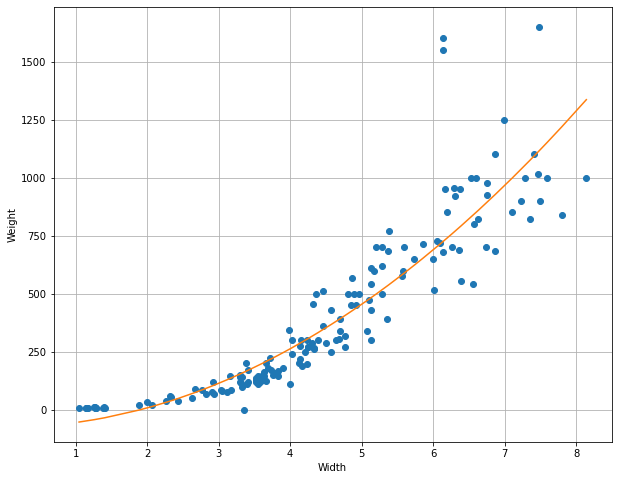

In [210]:
fig, ax = plt.subplots(figsize=(10, 8))

pred_poly = result_poly.predict(data.Width)

plt.plot(data.Width, data.Weight,'o')
plt.xlabel('Width')
plt.ylabel('Weight')

pfit = pd.DataFrame(columns = ['Width','Pred'])
pfit.Width = data.Width
pfit.Pred = pred_poly
pfit = pfit.sort_values(by=['Width'])
plt.plot(pfit.Width, pfit.Pred)
plt.grid()

# Spline

In [92]:
formula = ('Weight ~ bs(Width, df=3, degree=2)')
model_spline = smf.ols(formula=formula, data=data)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     289.8
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.55e-63
Time:                        22:14:30   Log-Likelihood:                -1010.0
No. Observations:                 159   AIC:                             2028.
Df Residuals:                     155   BIC:                             2040.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Text(53.5, 0.5, 'Weight')

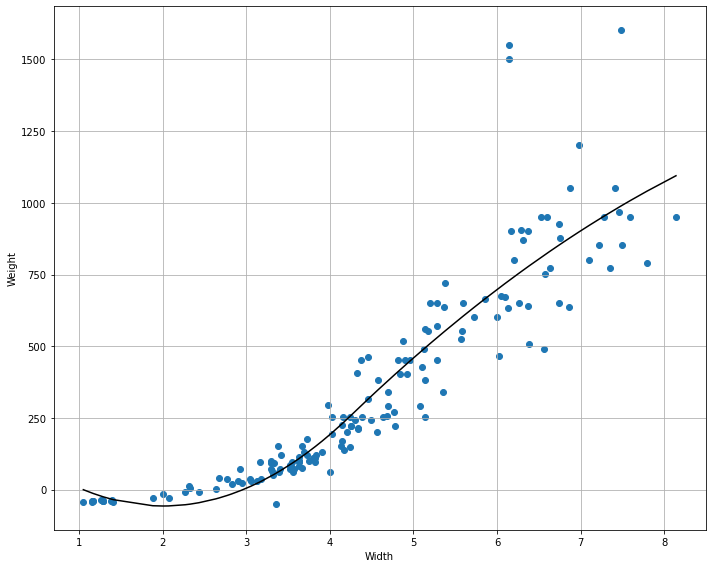

In [168]:
fig, ax = plt.subplots(figsize=(10, 8))
partialResidualPlot(result_spline, data, 'Weight', 'Width', ax)

plt.tight_layout()
plt.grid()
plt.xlabel('Width')
plt.ylabel('Weight')

# GAM

In [108]:
data

,Species,Length1,Length2,Length3,Height,Width,Weight
0,Bream,23.2,25.4,30.0,11.5200,4.0200,242.0
1,Bream,24.0,26.3,31.2,12.4800,4.3056,290.0
2,Bream,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Bream,26.3,29.0,33.5,12.7300,4.4555,363.0
4,Bream,26.5,29.0,34.0,12.4440,5.1340,430.0
...,...,...,...,...,...,...,...
154,Smelt,11.5,12.2,13.4,2.0904,1.3936,12.2
155,Smelt,11.7,12.4,13.5,2.4300,1.2690,13.4
156,Smelt,12.1,13.0,13.8,2.2770,1.2558,12.2
157,Smelt,13.2,14.3,15.2,2.8728,2.0672,19.7


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


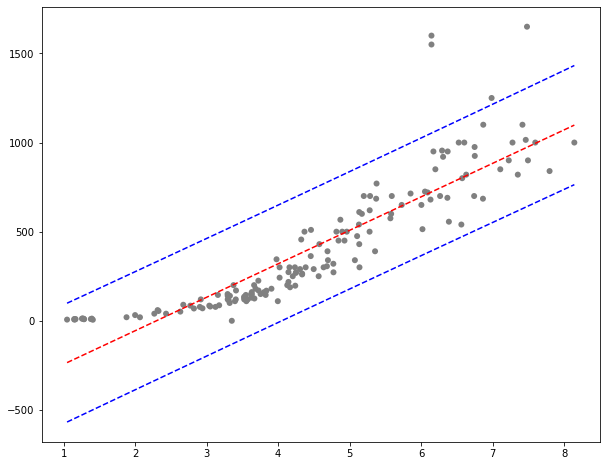

In [214]:
predictors = ['Width']
outcome = ['Weight']
x = data[predictors].values
y = data[outcome]

gam = LinearGAM(l(0))
gam.gridsearch(x, y)

fig, ax = plt.subplots(figsize=(10, 8))

XX = gam.generate_X_grid(term=0)
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.scatter(X, y, facecolor='gray', edgecolors='none')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


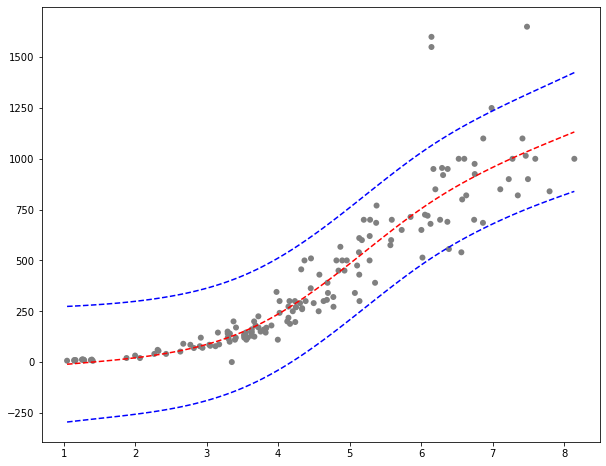

In [217]:
predictors = ['Width']
outcome = ['Weight']
x = data[predictors].values
y = data[outcome]

gam = LinearGAM(s(0, n_splines=20))
gam.gridsearch(x, y)

fig, ax = plt.subplots(figsize=(10, 8))

XX = gam.generate_X_grid(term=0)
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.scatter(X, y, facecolor='gray', edgecolors='none')